# Modeling Police Favorability with UCLA Data

In this notebook, I threw a ton of models at the wall to see what would stick. In the end, I discovered that I couldn't manage to get my R<sup>2</sup> score above .27 or so. My best model was the VotingRegressor that ensembled linear regression, lasso, random forest, and gradient boost models for a score of .2794. But even with that best score, the RMSE was .3065; in other words, when trying to predict a value between 0 and 1, my model's predictions are off by an average of .3 or 30%. So the model itself might not be that helpful, but perhaps there is something to learn from the features and their relative importances. The top ten most important features were `age, race_ethnicity_black, household_income, race_ethnicity_white, religion_atheist, fc_smallgov, news_sources_cnn, news_sources_msnbc, household_gun_owner_no, news_sources_npr, education, religion_agnostic, employment_employed,` and `religion_none`. 

## Imports and prep

After importing the various libraries and packages I'm going to use in this section, I split the dataset into training and testing sets, scaled my features, and used MinMaxScaler to put the target variable (police favorability) on a scale of 0 to 1. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
df = pd.read_csv('../data/ucla_cleaned.csv')
df.head()

,group_favorability_the_police,news_sources_facebook,news_sources_cnn,news_sources_msnbc,news_sources_fox,news_sources_network,news_sources_localtv,news_sources_telemundo,news_sources_npr,news_sources_amtalk,...,race_ethnicity_black,race_ethnicity_native,race_ethnicity_pacific_islander,race_ethnicity_white,household_gun_owner_no,household_gun_owner_yes,region_midwest,region_northeast,region_south,region_west
0,3.0,1,0,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,4.0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
2,4.0,1,0,0,1,1,1,0,0,1,...,0,0,0,1,1,0,0,0,1,0
3,4.0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
4,4.0,0,0,0,1,0,1,0,0,0,...,0,0,0,1,1,0,1,0,0,0


In [3]:
X = df.drop(columns = 'group_favorability_the_police')
y = df['group_favorability_the_police']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42, stratify = y)

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

mm = MinMaxScaler()

# putting target variable on 0-1 scale
y_train = mm.fit_transform(np.array(y_train).reshape(-1, 1))[:,0]
y_test = mm.transform(np.array(y_test).reshape(-1, 1))[:,0]

## Throwing models at the wall and seeing what sticks

In this section, I created a for loop to see which models seemed to be the best fit for this project. I mostly focused on the testing scores when evaluating these, but was also interested in the range of predictions and the pattern of residuals. I moved forward with the four models from the loop with the highest testing scores to experiment further.

KNeighborsRegressor() 

Training score: 0.3572 , Testing score: 0.0076 

Baseline: 2.8169 , Pred mean: 0.7813 , Pred variance: 0.0044


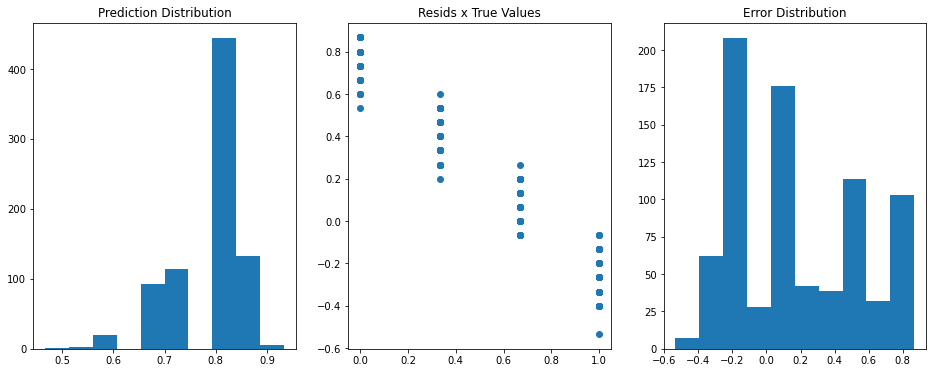

LassoCV() 

Training score: 0.2792 , Testing score: 0.2462 

Baseline: 2.8169 , Pred mean: 4.4631 , Pred variance: 1.7851


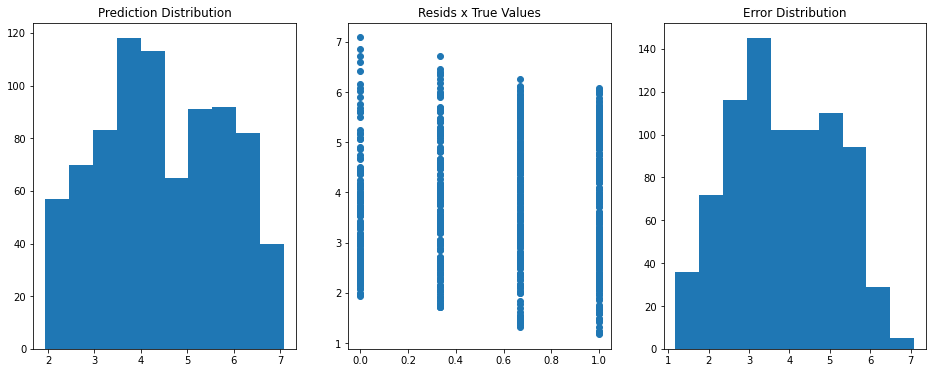

LinearRegression() 

Training score: 0.2988 , Testing score: 0.2541 

Baseline: 2.8169 , Pred mean: -429715562792.1386 , Pred variance: 4.96578117127357e+22


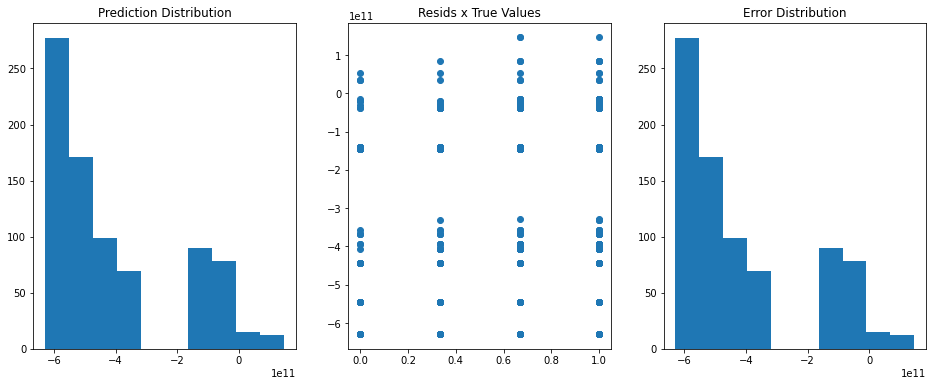

RandomForestRegressor() 

Training score: 0.8932 , Testing score: 0.2431 

Baseline: 2.8169 , Pred mean: 0.6475 , Pred variance: 0.0149


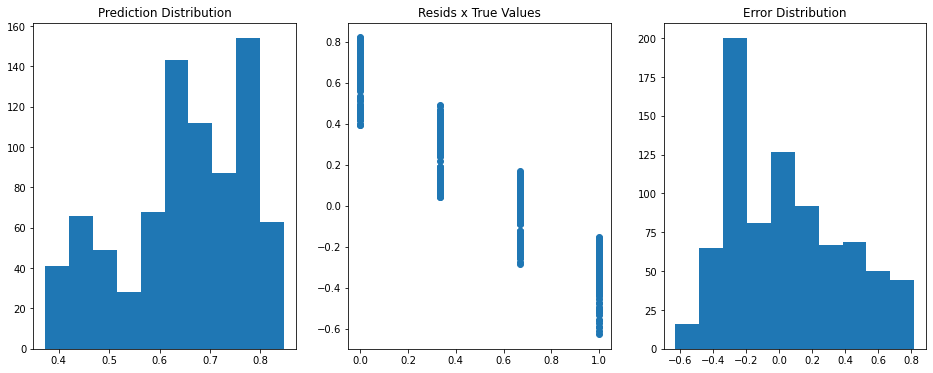

GradientBoostingRegressor() 

Training score: 0.384 , Testing score: 0.2552 

Baseline: 2.8169 , Pred mean: 0.7123 , Pred variance: 0.0055


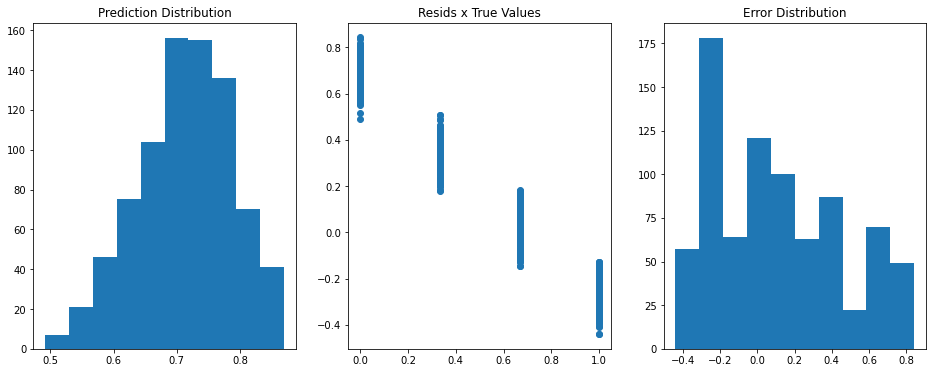

AdaBoostRegressor() 

Training score: 0.1901 , Testing score: 0.151 

Baseline: 2.8169 , Pred mean: 0.6261 , Pred variance: 0.0001


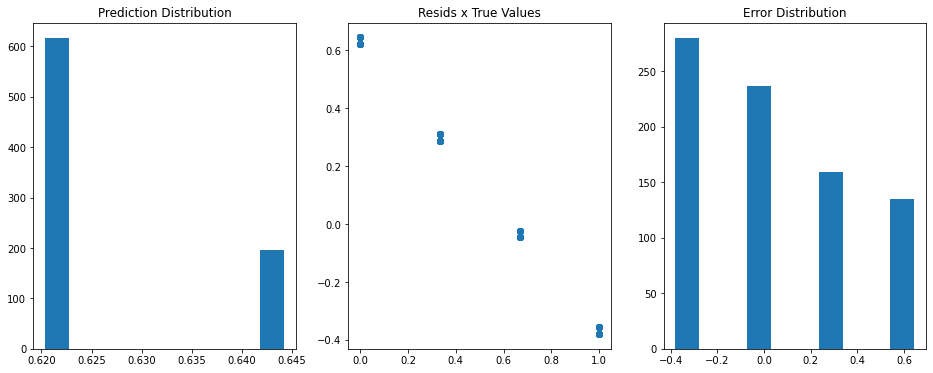

In [4]:
# looping through various model types, fitting them, and evaluating them
for model in [KNeighborsRegressor(), LassoCV(), LinearRegression(), RandomForestRegressor(), \
              GradientBoostingRegressor(), AdaBoostRegressor()]:
    model.fit(X_train_sc, y_train)
    print(model, '\n\nTraining score:',round(model.score(X_train_sc,y_train),4),
          ', Testing score:', round(model.score(X_test_sc,y_test),4), '\n')
    preds = model.predict(X_test)
    resids = preds - y_test
    
    print('Baseline:',round(df.group_favorability_the_police.mean(),4), ', Pred mean:', round(preds.mean(),4), \
          ', Pred variance:', round(np.var(preds),4))
    
    plt.figure(figsize = (16,6))
    
    pred = plt.subplot(1,3,1)
    res = plt.subplot(1,3,2)
    err = plt.subplot(1,3,3)
    
    pred.hist(preds)
    pred.set_title('Prediction Distribution')
    
    res.scatter(y_test, resids)
    res.set_title('Resids x True Values')
    
    err.hist(resids)
    err.set_title('Error Distribution')
    
    plt.show()

I'm going to move forward with the four best performing models from the above loop: 

- LinearRegression

- LassoCV 

- RandomForestRegressor 

- GradientBoostingRegressor


## Further experimentation
In this section, I define two functions to help extradite the experimentation process in terms of evaluating the success of a model and interpreting the meaning of the coefficients or feature importances. Then I utilize them to narrow down the list of features in an attempt to make my models more generalizable (with some success!).

In [5]:
# creating function to quickly print training score, testing score, and RMSE
def scores(model,X=X):
    X_tr = X.loc[X_train.index]
    X_te = X.loc[X_test.index]
    
    sc = StandardScaler()

    X_tr = sc.fit_transform(X_tr)
    X_te = sc.transform(X_te)
    
    
    model.fit(X_tr,y_train)
    train_score = model.score(X_tr,y_train)
    test_score = model.score(X_te,y_test)
    
    return print('Training score:',round(train_score,4),
                 ',  Testing score:',round(test_score,4),
                 '\nRMSE:', metrics.mean_squared_error(y_test,model.predict(X_te)) ** 0.5)

# creating function to capture `num_feats` number of 
# the most important features from a model after it's been fit
def get_feats(model, c_or_i, num_feats,X = X):
    if c_or_i == 'importance':
        coefs = model.feature_importances_
    else:
        coefs = model.coef_
        
    df = pd.DataFrame(abs(coefs), X.columns, columns = ['coefs'])
    df.sort_values('coefs', ascending = False, inplace = True)
    return df.index[:num_feats]

### Grid searched scores prior to feature selection

I removed the GridSearchCV code because it was too much for my computer to run multiple times, but I instantiate the models below with their `best_params_`. Using those grid searched parameters, I gathered the model scores to compare them to the hopefully more generalizable models with fewer features.

In [6]:
lr = LinearRegression()
las = LassoCV(random_state = 42)
rf = RandomForestRegressor(max_depth = 5, min_samples_split = 4,
                           n_estimators = 200, random_state = 42)
gb = GradientBoostingRegressor(min_samples_split = 3, random_state = 42)

In [7]:
# capturing top 33 features from each model (explained a bit more below)
feat_list = []

for model,c_or_i,name in zip([lr,las,rf,gb],['coef','coef','importance','importance'],['LR','Lasso','RF','GB']):
    model.fit(X_train_sc,y_train)
    feat_list.extend(get_feats(model,c_or_i,33))
    print(name)
    scores(model)

LR
Training score: 0.2988 ,  Testing score: 0.2541 
RMSE: 0.31183814264089915
Lasso
Training score: 0.2792 ,  Testing score: 0.2462 
RMSE: 0.3135029317959428
RF
Training score: 0.3136 ,  Testing score: 0.2187 
RMSE: 0.3191556918298228
GB
Training score: 0.3835 ,  Testing score: 0.2514 
RMSE: 0.3124159476944764


### Grid searched scores after feature selection

Now I'm going to use that narrowed feature list in the same models to see if there is any improvement. I played around with various values for the number of features I extract from each model and settled on 33 (used above) as a good number. It's still a long list of features but this cutoff seemed to have the best outcomes!

In [8]:
# keeping track of the lists of features for all possible cutoffs to make my life easier later

lr = LinearRegression()
las = LassoCV(random_state = 42)
rf = RandomForestRegressor(max_depth = 5, min_samples_split = 4,
                           n_estimators = 200, random_state = 42)
gb = GradientBoostingRegressor(min_samples_split = 3, random_state = 42)

feat_dict = {}

for i in range(10,109):
    for model,c_or_i,name in zip([lr,las,rf,gb],['coef','coef','importance','importance'],['LR','Lasso','RF','GB']):
        model.fit(X_train_sc,y_train)
        feat_dict[i] = get_feats(model,c_or_i,i)

In [9]:
# reinstantiating X variables with narrowed set of features
feats = set(feat_list)

X_narrow = df[feats]
X_train_narrow = X_narrow.loc[X_train.index]
X_test_narrow = X_narrow.loc[X_test.index]

sc = StandardScaler()

X_train_narrow_sc = sc.fit_transform(X_train_narrow)
X_test_narrow_sc = sc.transform(X_test_narrow)

In [10]:
# re-running models with narrowed features
lr = LinearRegression()
las = LassoCV(random_state = 42)
rf = RandomForestRegressor(max_depth = 5, min_samples_split = 4
                           , n_estimators = 200, random_state = 42)
gb = GradientBoostingRegressor(min_samples_split = 3, random_state = 42)

# keeping track of scores to use as weights in my voting regressors
test_scores = []

for model,name in zip([lr,las,rf,gb],['LR','Lasso','RF','GB']):
    model.fit(X_train_narrow_sc,y_train)
    print('\n'+name)
    test_scores.append(model.score(X_test_narrow_sc,y_test))
    scores(model, X = X[feats])


LR
Training score: 0.2932 ,  Testing score: 0.2441 
RMSE: 0.31393490317570416

Lasso
Training score: 0.2856 ,  Testing score: 0.2485 
RMSE: 0.3130201318301129

RF
Training score: 0.3132 ,  Testing score: 0.2178 
RMSE: 0.3193470945115728

GB
Training score: 0.3811 ,  Testing score: 0.2468 
RMSE: 0.31337325789234505


**Some success!** The models seem to be a bit more generalizable now that I've narrowed the features a bit. 

### Trying a voting regressor
I'd like to be able to ensemble these models if possible so I'm going to try throwing these into a VotingRegressor. I played around with various cutoffs and found 44 to be the most successful.

In [11]:
# reinstantiating models with grid searched parameters for use in the voting regressor
lr = LinearRegression()
las = LassoCV(random_state = 42)
rf = RandomForestRegressor(max_depth = 10, min_samples_split = 3, n_estimators = 200, random_state = 42)
gb = GradientBoostingRegressor(min_samples_split = 3, random_state = 42)

weights = [score/sum(test_scores) for score in test_scores] # using scores from above to weight the models

vote = VotingRegressor([
    ('lr', lr),
    ('las',las),
    ('rf', rf),
    ('gb', gb)],
    weights = weights)

# i played around with various values and found that 44 features was the best performing cutoff for this model
scores(vote, X = X[feat_dict[44]])

Training score: 0.4114 ,  Testing score: 0.2607 
RMSE: 0.3104589852550621


**Yay! Best score yet.** Before I move on to my next experiment, I'm going to see how neural nets perform for this project.

### Trying neural nets

All feats 
Training score: 0.9294 , Testing score: -0.1592 , RMSE: 0.3888 

Narrowed 
Training score: 0.8941 , Testing score: -0.1094 , RMSE: 0.3803 



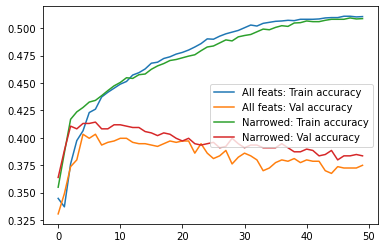

In [12]:
# trying neural nets with all features and more narrowed features
for name, X_tr, X_te in zip(['All feats','Narrowed'],[X_train_sc,X_train_narrow_sc],[X_test_sc,X_test_narrow_sc]):
    nn = Sequential()
    nn.add(Dense(128,
                    input_shape = (X_tr.shape[1],),
                    activation = 'relu'))
    nn.add(Dense(64,activation = 'relu'))
    nn.add(Dense(32,activation = 'relu'))
    nn.add(Dense(1, activation='sigmoid'))

    nn.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

    history = nn.fit(X_tr, y_train, validation_data=(X_te, y_test),
                     epochs=50, batch_size=512, verbose=0)
    
    train_score = round(metrics.r2_score(y_train,nn.predict(X_tr)),4)
    test_score = round(metrics.r2_score(y_test,nn.predict(X_te)),4)
    rmse = round(metrics.mean_squared_error(y_test,nn.predict(X_te)) ** 0.5,4)
    
    print(name,'\nTraining score:',train_score,', Testing score:',test_score, ', RMSE:',rmse,'\n')

    plt.plot(history.history['accuracy'], label=name+': Train accuracy')
    plt.plot(history.history['val_accuracy'], label=name+': Val accuracy')
    plt.legend();

**That did not work very well.** Nevermind about the neural nets! 

### Finding unique feature sets for each type of model
Now I'm going to see if there are different cutoffs that work best for each of my four best models by looping through a ton of different possibilities and keeping track of the highest performing parameters.

In [13]:
# establishing variables to overwrite to keep track of my best parameters and make my code more dynamic
best_combo = ('model',0)
best_score = 0

best_lr_combo = 0
best_lr_score = 0

best_las_combo = 0
best_las_score = 0

best_rf_combo = 0
best_rf_score = 0

best_gb_combo = 0
best_gb_score = 0

lr = LinearRegression()
las = LassoCV(random_state = 42)
rf = RandomForestRegressor(max_depth = 5, min_samples_split = 4,
                       n_estimators = 200, random_state = 42)
gb = GradientBoostingRegressor(min_samples_split = 3, random_state = 42)
    

In [14]:
# trying all combinations of models and cutoffs and keeping track of the best outcomes for each model
for model,c_or_i,name in zip([lr,las,rf,gb],['coef','coef','importance','importance'],['LR','Lasso','RF','GB']):
    for i in range(10,109):
        feat_list = feat_dict[i]
        X_tr = X[feat_list].loc[X_train.index]
        X_te = X[feat_list].loc[X_test.index]

        sc = StandardScaler()

        X_tr = sc.fit_transform(X_tr)
        X_te = sc.transform(X_te)
        
        model.fit(X_tr,y_train)
        score = model.score(X_te,y_test)
        if score > best_score:
            best_score = score
            best_combo = (name,i)
            
        if name == 'LR' and score > best_lr_score:
            best_lr_score = score
            best_lr_combo = i

        elif name == 'Lasso' and score > best_las_score:
            best_las_score = score
            best_las_combo = i

        elif name == 'RF' and score > best_rf_score:
            best_rf_score = score
            best_rf_combo = i

        elif name == 'GB' and score > best_gb_score:
            best_gb_score = score
            best_gb_combo = i
            
print('Best LR score:', best_lr_score, ', Best LR combo:', best_lr_combo,'\n')
print('Best Lasso score:', best_las_score, ', Best Lasso combo:', best_las_combo,'\n')
print('Best RF score:', best_rf_score, ', Best RF combo:', best_rf_combo,'\n')
print('Best GB score:', best_gb_score, ', Best GB combo:', best_gb_combo,'\n')
print('\nBest score:', best_score, ', Best combo:', best_combo)

Best LR score: 0.2587719185089983 , Best LR combo: 75 

Best Lasso score: 0.25287683798321026 , Best Lasso combo: 49 

Best RF score: 0.219549704686264 , Best RF combo: 62 

Best GB score: 0.2564282194959928 , Best GB combo: 51 


Best score: 0.2587719185089983 , Best combo: ('LR', 75)


**That helped the individual scores a tiny bit but, like I said, I'd love to ensemble the models if possible.** Since I can't use different features for each model in a voting ensemble, I'm going to make my own. 

### Manual voting regressor model

Below, I use the test scores from above to weight the models, create predictions using the best cutoff for each model, and then calculate a weighted average for each prediction.

In [16]:
# reinstantiating models with grid searched parameters for use in the manual voting regressor model
lr = LinearRegression()
las = LassoCV(random_state = 42)
rf = RandomForestRegressor(max_depth = 10, min_samples_split = 3, n_estimators = 200, random_state = 42)
gb = GradientBoostingRegressor(min_samples_split = 3, random_state = 42)

# creating weights based on the performances of the models above
test_scores = [best_lr_score,best_las_score,best_rf_score,best_gb_score]
weights = [score/(best_lr_score + best_las_score + best_rf_score + best_gb_score) for score in test_scores]

# creating a dataframe to store the weighted predictions so i can ensemble more easily
pred_df = pd.DataFrame()

# creating and fitting models with best parameters and generating predictions in the dataframe
for model, name, weight, n in zip([lr,las,rf,gb],['LR','Lasso','RF','GB'],weights,                             
    [best_lr_combo,best_las_combo,best_rf_combo,best_gb_combo]):
    
    spaces = ' '*(5-len(name))
    print(name+':',spaces,n,'features')
    
    feats = feat_dict[n]
    X_tr = X[feats].loc[X_train.index]
    X_te = X[feats].loc[X_test.index]

    sc = StandardScaler()
    X_tr = sc.fit_transform(X_tr)
    X_te = sc.transform(X_te)
    
    model.fit(X_tr,y_train)
    preds = model.predict(X_te)
    
    pred_df[name] = list(preds * weight)

# summing the weighted predictions to produce a final prediction
pred_df['pred'] = sum([pred_df['LR'],pred_df['Lasso'],pred_df['RF'],pred_df['GB']])

# evaluating
print('\nTesting score:',metrics.r2_score(y_test, list(pred_df['pred'])))
print('RMSE:',metrics.mean_squared_error(y_test,list(pred_df['pred']))**0.5)

LR:     75 features
Lasso:  49 features
RF:     62 features
GB:     51 features

Testing score: 0.2672963826479843
RMSE: 0.30907611352303643


**The best score yet!** Yay! I think this is just about as good as it's going to get.

## Final model selection

So my best model was the manual voting regressor that ensembled linear, lasso, random forest, and gradient boost regression models with 46, 46, 32, and 18 features respectively. Now I'm going to look at the features and their coefficients to interpret the results.

In [17]:
# finding the average importance of each feature in the four final models
coef_df = pd.DataFrame()
coef_df['feature'] = X.columns

for model, name, c_or_i, n in zip([lr,las,rf,gb],['LR','Lasso','RF','GB'],
                               ['coef','coef','importance','importance'],
                               [best_lr_combo,best_las_combo,best_rf_combo,best_gb_combo]):
    
    feats = feat_dict[n]
    
    model_coef_df = pd.DataFrame()
    model_coef_df['feature'] = feats

    X_tr = X[feats].loc[X_train.index]
    X_te = X[feats].loc[X_test.index]
    
    sc = StandardScaler()
    X_tr = sc.fit_transform(X_tr)
    X_te = sc.transform(X_te)
    
    model.fit(X_tr,y_train)
    
    if c_or_i == 'importance':
        model_coef_df[name] = model.feature_importances_
    else: 
        model_coef_df[name] = model.coef_
    
    coef_df = pd.merge(coef_df, model_coef_df, how = 'left', on = 'feature')
    
coef_df.fillna(0,inplace=True)    
coef_df['avg'] = (coef_df['LR'] + coef_df['Lasso'] + coef_df['RF'] + coef_df['GB']) / 4

In [18]:
coef_df.fillna(0,inplace=True)    
coef_df['avg'] = (coef_df['LR'] + coef_df['Lasso'] + coef_df['RF'] + coef_df['GB']) / 4
coef_df['abs_avg'] = abs(coef_df['avg'])

## Top ten features

In [19]:
coef_df.loc[coef_df['abs_avg'] >= 0.01,:].sort_values('abs_avg',ascending=False)[['feature','avg']]


,feature,avg
14,age,0.150655
100,race_ethnicity_white,0.081279
3,news_sources_fox,0.044078
16,household_income,0.039295
12,religion_evangelical,0.030151
80,religion_catholic,0.020691
17,education,0.019675
81,religion_christian,0.017686
102,household_gun_owner_yes,0.016645
5,news_sources_localtv,0.015427
